In [1]:
%run ./PPS_Expansion_Model.ipynb

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

## HC Training Parameters

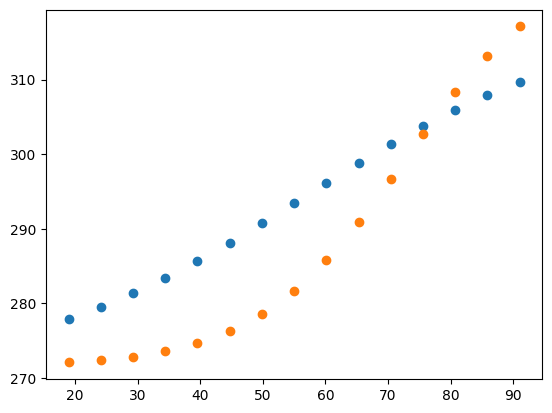

In [3]:
##Pre-Training
###Healthy Controls
ymin = 270.0
ymax = 318.5
fprHCCP = 100 - 1.448 * v
fprHCS = 1 / 0.0435

HC_RTs = RTsig(a_distances, fprHCCP, fprHCS)

##Post-Training
###Healthy Controls
ymin = 271.5
ymax = 326.5
fpostHCCP = 100 - 0.920 * v
fpostHCS = 1 / 0.085

HC_RTs_post = RTsig(a_distances, fpostHCCP, fpostHCS)

plt.scatter(a_distances, HC_RTs)
plt.scatter(a_distances, HC_RTs_post)

In [4]:
k_a = 5e-05
k_v = 5e-05
stim_counts = 10
locav_x = 60

rho_0, siga_x, sigv_x = 6.137e-02, 6.992e01, 2.889e00

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=2.603e01,
    k2=7.795e02,
    lim=2.009e01,
    alpha=9.415e-01,
)

## SCZ Training

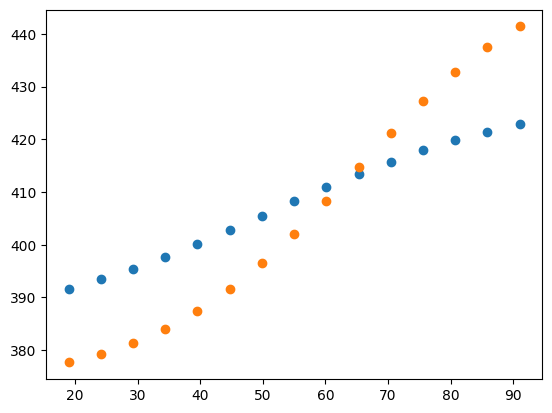

In [5]:
##Pre-Training
###SCZ
ymin = 382.5
ymax = 429.5
scz_cp = 100 - 1.6415 * 30
scz_slope = 1 / 0.0450

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

##Post-Training
###SCZ
ymin = 373.0
ymax = 455.0
scz_cp_post = 100 - 1.176 * v
scz_slope_post = 1 / 0.0615

SCZ_RTs_post = RTsig(a_distances, scz_cp_post, scz_slope_post)

plt.scatter(a_distances, SCZ_RTs)
plt.scatter(a_distances, SCZ_RTs_post)

## SCZ L_ex Model

In [6]:
## Pre -training model

Lex, Pr = 7.886e-01, 0

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_RTs_model_pre_lex_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

### Post-trainig model

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_lex_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

In [7]:
scz_error = calculate_adj_rmse(SCZ_RTs_model_post_lex_scaled, SCZ_RTs_post, 3)
print(scz_error)

4.3596706767482605


In [8]:
ymin, ymax = np.min(SCZ_RTs_model_pre_lex_scaled), np.max(SCZ_RTs_model_pre_lex_scaled)
SCZ_Lex_CP_model_pre, SCZ_Lex_SLOPE_model_pre = fitting(
    a_distances, SCZ_RTs_model_pre_lex_scaled
)

ymin, ymax = np.min(SCZ_RTs_model_post_lex_scaled), np.max(
    SCZ_RTs_model_post_lex_scaled
)
SCZ_Lex_CP_model_post, SCZ_Lex_SLOPE_model_post = fitting(
    a_distances, SCZ_RTs_model_post_lex_scaled
)

## SCZ Pr Model

In [9]:
## Pre -training model

Lex, Pr = 0.15, 2.801e-01

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_RTs_model_pre_pr_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

### Post-trainig model

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_pr_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

In [10]:
scz_error = calculate_adj_rmse(SCZ_RTs_model_post_pr_scaled, SCZ_RTs_post, 3)
print(scz_error)

4.373476796752359


In [11]:
ymin, ymax = np.min(SCZ_RTs_model_pre_pr_scaled), np.max(SCZ_RTs_model_pre_pr_scaled)
SCZ_Pr_CP_model_pre, SCZ_Pr_SLOPE_model_pre = fitting(
    a_distances, SCZ_RTs_model_pre_pr_scaled
)

ymin, ymax = np.min(SCZ_RTs_model_post_pr_scaled), np.max(SCZ_RTs_model_post_pr_scaled)
SCZ_Pr_CP_model_post, SCZ_Pr_SLOPE_model_post = fitting(
    a_distances, SCZ_RTs_model_post_pr_scaled
)

## SCZ Lex - Pr Model

In [12]:
## Pre -training model

Lex, Pr = 7.887e-01, 4.773e-01

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    CMpr=0,
)

SCZ_RTs_model_pre_lex_pr_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

### Post-trainig model

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    n_steps=stim_counts,
    T=simtime,
    ts=ts,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=Pr,
    rho_0=rho_0,
    Wmax_a=6.5,
    Wmax_v=6.5,
    k_a=k_a,
    k_v=k_v,
    theta=0.05,
    locav_x=locav_x,
    siga_x=siga_x,
    sigv_x=sigv_x,
)

_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=SCZWa_tr[:, :, -1, -1],
    Wv=SCZWv_tr[:, :, -1, -1],
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_RTs_model_post_lex_pr_scaled = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

In [13]:
scz_error = calculate_adj_rmse(SCZ_RTs_model_post_lex_pr_scaled, SCZ_RTs_post, 4)
print(scz_error)

4.553527512882768


In [14]:
ymin, ymax = np.min(SCZ_RTs_model_pre_lex_pr_scaled), np.max(
    SCZ_RTs_model_pre_lex_pr_scaled
)
SCZ_Lex_Pr_CP_model_pre, SCZ_Lex_Pr_SLOPE_model_pre = fitting(
    a_distances, SCZ_RTs_model_pre_lex_pr_scaled
)

ymin, ymax = np.min(SCZ_RTs_model_post_lex_pr_scaled), np.max(
    SCZ_RTs_model_post_lex_pr_scaled
)
SCZ_Lex_Pr_CP_model_post, SCZ_Lex_Pr_SLOPE_model_post = fitting(
    a_distances, SCZ_RTs_model_post_lex_pr_scaled
)

In [15]:
cols = ["Model", "Training", "Central Point (cm)", "Slope"]
sim_data = np.array(
    [
        ["SCZ - L_ex", "Pre", SCZ_Lex_CP_model_pre, 1 / SCZ_Lex_SLOPE_model_pre],
        ["SCZ - L_ex", "Post", SCZ_Lex_CP_model_post, 1 / SCZ_Lex_SLOPE_model_post],
        ["SCZ - rho_W", "Pre", SCZ_Pr_CP_model_pre, 1 / SCZ_Pr_SLOPE_model_pre],
        ["SCZ - rho_W", "Post", SCZ_Pr_CP_model_post, 1 / SCZ_Pr_SLOPE_model_post],
        [
            "SCZ - L_ex - rho_W",
            "Pre",
            SCZ_Lex_Pr_CP_model_pre,
            1 / SCZ_Lex_Pr_SLOPE_model_pre,
        ],
        [
            "SCZ - L_ex - rho_W",
            "Post",
            SCZ_Lex_Pr_CP_model_post,
            1 / SCZ_Lex_Pr_SLOPE_model_post,
        ],
        ["HC", "Pre", fprHCCP, 1 / fprHCS],
        ["HC", "Post", fpostHCCP, 1 / fpostHCS],
        ["SCZ", "Pre", scz_cp, 1 / scz_slope],
        ["SCZ", "Post", scz_cp_post, 1 / scz_slope_post],
    ]
)
sim_df = pd.DataFrame(sim_data, columns=cols)
sim_df[["Central Point (cm)", "Slope"]] = sim_df[
    ["Central Point (cm)", "Slope"]
].astype(float)
sim_df

,Model,Training,Central Point (cm),Slope
0,SCZ - L_ex,Pre,53.605818,0.084232
1,SCZ - L_ex,Post,65.235008,0.102630
2,SCZ - rho_W,Pre,55.000000,0.079706
3,SCZ - rho_W,Post,65.804113,0.107294
4,SCZ - L_ex - rho_W,Pre,53.605818,0.084232
5,SCZ - L_ex - rho_W,Post,65.235008,0.102630
6,HC,Pre,56.560000,0.043500
7,HC,Post,72.400000,0.085000
8,SCZ,Pre,50.755000,0.045000
9,SCZ,Post,64.720000,0.061500


In [16]:
import seaborn as sns

sns.set_context("paper")
sns.set_theme(
    style="ticks",
    palette=["black", "black", "black", "gray", "gray"],
    rc={"axes.labelsize": 14, "axes.labelweight": "bold"},
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


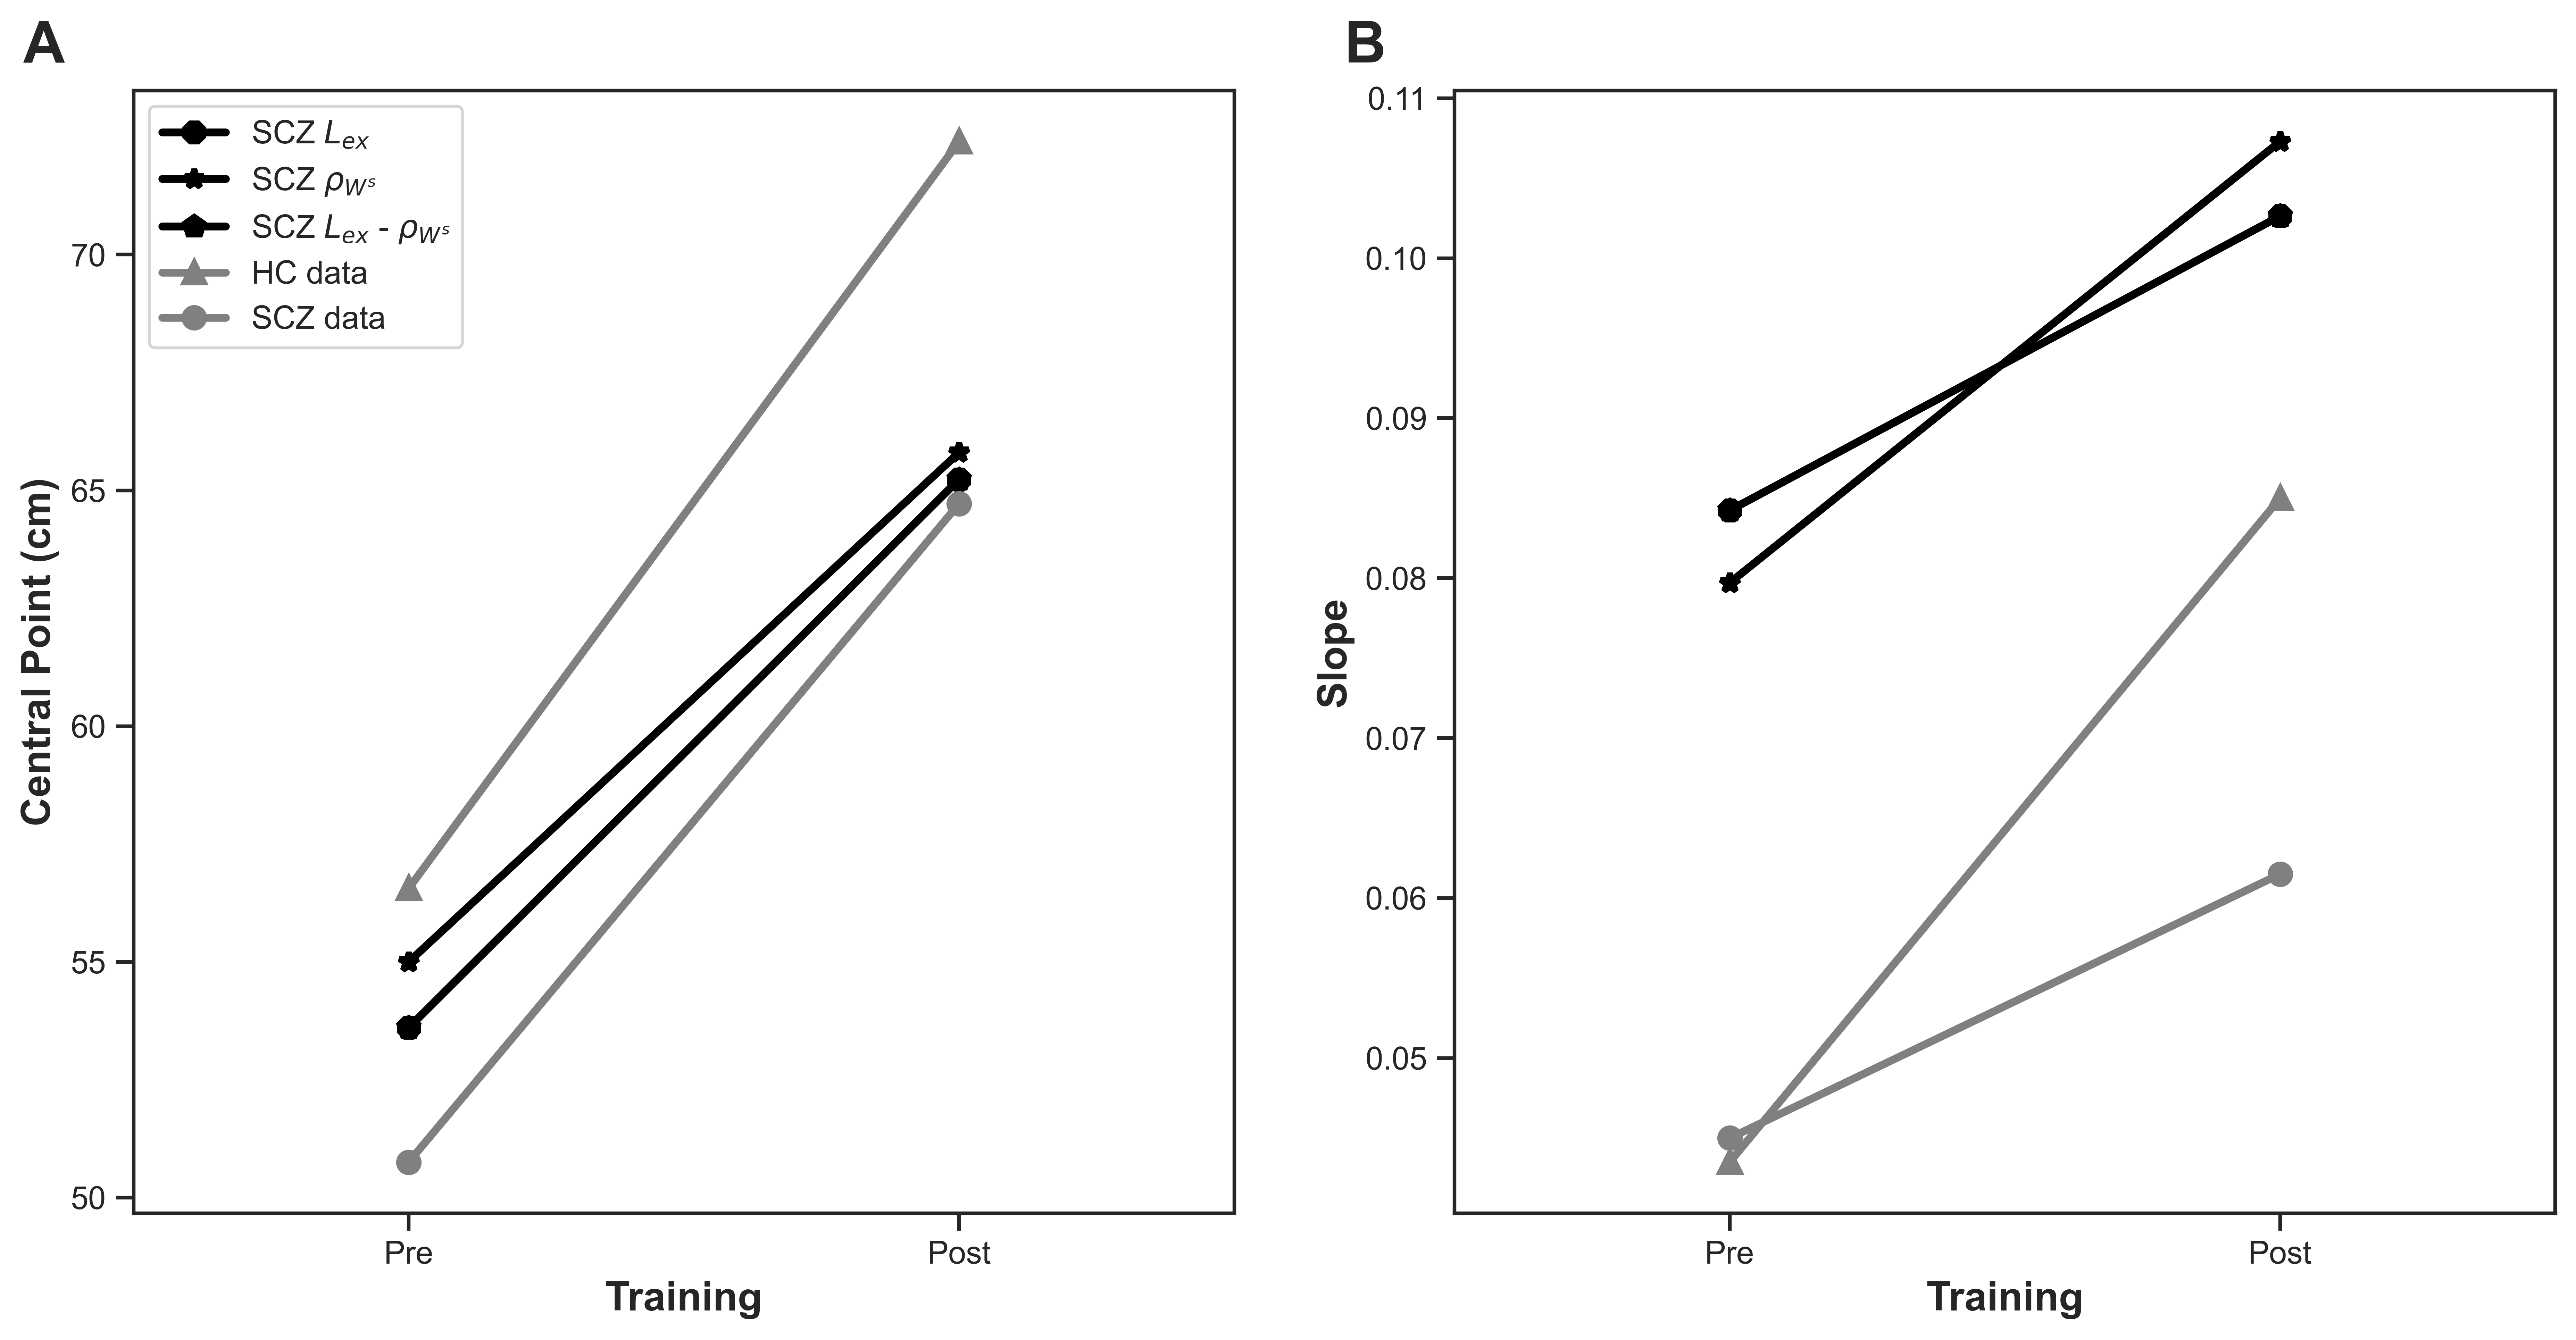

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), dpi=600)

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
sns.pointplot(
    x="Training",
    y="Central Point (cm)",
    hue="Model",
    data=sim_df,
    ax=ax1,
    markers=["8", "*", "p", "^", "o"],
)
sns.pointplot(
    x="Training",
    y="Slope",
    hue="Model",
    data=sim_df,
    ax=ax2,
    markers=["8", "*", "p", "^", "o"],
)

ax1.text(
    -0.1,
    1.025,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2.text(
    -0.1,
    1.025,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

handles, _ = ax1.get_legend_handles_labels()
labels = [
    "SCZ $L_{ex}$",
    "SCZ " + r"$\rho_{{W}^{s}}$",
    "SCZ $L_{ex}$ - " + r"$\rho_{{W}^{s}}$",
    "HC data",
    "SCZ data",
]
ax1.legend(handles, labels)
ax2.get_legend().remove()

fig.savefig("drafts/FIG3.eps", bbox_inches="tight", format="eps")

In [18]:
df_pivoted = sim_df.pivot(
    index="Model", columns="Training", values=["Central Point (cm)", "Slope"]
)

delta_sim_df = pd.DataFrame()
delta_sim_df["Delta CP"] = (
    df_pivoted[("Central Point (cm)", "Post")]
    - df_pivoted[("Central Point (cm)", "Pre")]
)
delta_sim_df["Delta Slope"] = (
    df_pivoted[("Slope", "Post")] - df_pivoted[("Slope", "Pre")]
)

delta_sim_df = delta_sim_df.reset_index()
delta_sim_df.round(3)

,Model,Delta CP,Delta Slope
0,HC,15.840,0.042
1,SCZ,13.965,0.016
2,SCZ - L_ex,11.629,0.018
3,SCZ - L_ex - rho_W,11.629,0.018
4,SCZ - rho_W,10.804,0.028
